## Skinsmiths UK Text Message for No Shows A/B Testing
#### Import Necessary Libraries

In [1]:
# Data Managment
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical operations and mathematical functions

# Data Visualisation
import matplotlib.pyplot as plt  # For creating static visualisations
import seaborn as sns  # For visualisations with enhanced aesthetics

# Statistical Analysis and Hypothesis Testing
from scipy import stats  # Core statistical tests (t-tests, chi-squared, ANOVA, normality tests, etc.)
import statsmodels.api as sm  # For advanced statistical models (e.g., linear regression, GLMs, robust estimation)
from statsmodels.stats.proportion import proportions_ztest  # Specifically for comparing proportions
from scipy.stats import ttest_1samp # For using the one sample test and dat assumption checking
import pandas as pd
from scipy.stats import chi2_contingency

# To handle warnings regarding deprecation of plot colour scheme
import warnings  # This is a one-off analysis; future-proofing is not required
import sys

### Import and Tidy Data

In [2]:
# Import datasets 
baseline = pd.read_csv('/Users/james_smith/Documents/SKS Texts/Baseline.csv')
test = pd.read_csv('/Users/james_smith/Documents/SKS Texts/Trial Data.csv', header=1) # Drop unecessary double header

In [3]:
# Set display options for readability
pd.set_option('display.expand_frame_repr', False)

In [4]:
# Print Baseline Data Head
print("Baseline Data:")
print(baseline.head())
# Print Test Data Head
print("\nTest Data:")
print(test.head())

Baseline Data:
              Clinic  Jan_Consults  Jan_NoShows  Feb_Consults  Feb_NoShows  Mar_Consults  Mar_NoShows
0      Clapham South            77           13            90           17            60           12
1       Tower Bridge            54            8            51            7            35            5
2  Wimbledon Village            48            8            72           12            63           10
3       Liverpool St            58            5            40            3            35            5
4              Esher            49            0            35            4            47            8

Test Data:
          Clinic      Condition  Consults  No_Shows  Showed_Up  Consults.1  No_Shows.1  Showed_Up.1
0  Clapham South        Control        19         5         14          22           6           16
1  Clapham South     ClientName        19         1         18          22           1           21
2  Clapham South  SchedulerName        19         2         1

In [5]:
# Print info for both data sets
test.info()
print('-' * 150) # Print horizontal line for readability
baseline.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Clinic       36 non-null     object
 1   Condition    36 non-null     object
 2   Consults     36 non-null     int64 
 3   No_Shows     36 non-null     int64 
 4   Showed_Up    36 non-null     int64 
 5   Consults.1   36 non-null     int64 
 6   No_Shows.1   36 non-null     int64 
 7   Showed_Up.1  36 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 2.4+ KB
------------------------------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Clinic        9 non-null      object
 1   Jan_Consults  9 non-null      int64 
 2   Jan_NoShows   

In [6]:
# Rename and tidy variable names
col_names = {'Clinic': 'clinic',
            'Condition':'condition',
            'Consults':'april_consults', 
            'No_Shows':'april_noshows',
            'Showed_Up':'april_shows',
            'Consults.1':'may_consults', 
            'No_Shows.1':'may_noshows',
            'Showed_Up.1':'may_shows'}

test.rename(mapper=col_names, axis=1, inplace=True)
print(test.head())

          clinic      condition  april_consults  april_noshows  april_shows  may_consults  may_noshows  may_shows
0  Clapham South        Control              19              5           14            22            6         16
1  Clapham South     ClientName              19              1           18            22            1         21
2  Clapham South  SchedulerName              19              2           17            22            1         21
3  Clapham South    Reciprocity              19              2           17            22            2         20
4   Tower Bridge        Control              13              3           10            13            4          9


In [7]:
# Convert column names to lowercase for consistency
baseline.columns = baseline.columns.str.lower()

In [8]:
# Create new columns for baseline data to match test data
baseline['condition'] = 'Baseline'
baseline['jan_shows'] = baseline['jan_consults'] - baseline['jan_noshows']
baseline['feb_shows'] = baseline['feb_consults'] - baseline['feb_noshows']
baseline['mar_shows'] = baseline['mar_consults'] - baseline['mar_noshows']

In [9]:
# Reorder columns for readability
baseline = baseline[['clinic', 'condition', 'jan_consults', 'jan_noshows', 'jan_shows','feb_consults', 'feb_noshows','feb_shows','mar_consults', 'mar_noshows','mar_shows']]

# Inspect the changes
print(baseline.head())

              clinic condition  jan_consults  jan_noshows  jan_shows  feb_consults  feb_noshows  feb_shows  mar_consults  mar_noshows  mar_shows
0      Clapham South  Baseline            77           13         64            90           17         73            60           12         48
1       Tower Bridge  Baseline            54            8         46            51            7         44            35            5         30
2  Wimbledon Village  Baseline            48            8         40            72           12         60            63           10         53
3       Liverpool St  Baseline            58            5         53            40            3         37            35            5         30
4              Esher  Baseline            49            0         49            35            4         31            47            8         39


In [10]:
# Reinspect the data 
print(baseline.head())
print('-'*150)
print(test.head())

              clinic condition  jan_consults  jan_noshows  jan_shows  feb_consults  feb_noshows  feb_shows  mar_consults  mar_noshows  mar_shows
0      Clapham South  Baseline            77           13         64            90           17         73            60           12         48
1       Tower Bridge  Baseline            54            8         46            51            7         44            35            5         30
2  Wimbledon Village  Baseline            48            8         40            72           12         60            63           10         53
3       Liverpool St  Baseline            58            5         53            40            3         37            35            5         30
4              Esher  Baseline            49            0         49            35            4         31            47            8         39
----------------------------------------------------------------------------------------------------------------------------------

## Exploatory Data Analysis

In [11]:
baseline.columns

Index(['clinic', 'condition', 'jan_consults', 'jan_noshows', 'jan_shows',
       'feb_consults', 'feb_noshows', 'feb_shows', 'mar_consults',
       'mar_noshows', 'mar_shows'],
      dtype='object')

In [12]:
# group no shows by clinic, ignore other columns for now
baseline_noshows = baseline.groupby(['clinic','condition']).agg({'jan_noshows':'mean','feb_noshows':'mean', 'mar_noshows':'mean'}).reset_index()
print(baseline_noshows)

              clinic condition  jan_noshows  feb_noshows  mar_noshows
0          Belgravia  Baseline         14.0          7.0          8.0
1             Bushey  Baseline          7.0         19.0          6.0
2      Clapham South  Baseline         13.0         17.0         12.0
3              Esher  Baseline          0.0          4.0          8.0
4            Hanwell  Baseline         12.0          5.0          9.0
5       Liverpool St  Baseline          5.0          3.0          5.0
6      Putney Bridge  Baseline          9.0         12.0          2.0
7       Tower Bridge  Baseline          8.0          7.0          5.0
8  Wimbledon Village  Baseline          8.0         12.0         10.0


In [13]:
# Calculate averages for each clinic and each month
baseline_noshows['baseline_average'] = np.mean(baseline_noshows[['jan_noshows', 'feb_noshows','mar_noshows']], axis=1)
baseline_noshows[['jan_noshows','feb_noshows','mar_noshows','baseline_average']] = baseline_noshows[['jan_noshows','feb_noshows','mar_noshows','baseline_average']].astype(int)
print(baseline_noshows)

              clinic condition  jan_noshows  feb_noshows  mar_noshows  baseline_average
0          Belgravia  Baseline           14            7            8                 9
1             Bushey  Baseline            7           19            6                10
2      Clapham South  Baseline           13           17           12                14
3              Esher  Baseline            0            4            8                 4
4            Hanwell  Baseline           12            5            9                 8
5       Liverpool St  Baseline            5            3            5                 4
6      Putney Bridge  Baseline            9           12            2                 7
7       Tower Bridge  Baseline            8            7            5                 6
8  Wimbledon Village  Baseline            8           12           10                10


In [14]:
# Calculate and append 'Average' row
#average_row = baseline_noshows.mean(numeric_only=True).round(0)
#average_row['clinic'] = 'Average'
#baseline_noshows = pd.concat([baseline_noshows, pd.DataFrame([average_row])], ignore_index=True)
#print(baseline_noshows)

# Calculate Monthly Averages for Comparison
jan_avg = int(round(baseline_noshows['jan_noshows'].mean()))
feb_avg = int(round(baseline_noshows['feb_noshows'].mean()))
mar_avg = int(round(baseline_noshows['mar_noshows'].mean()))

print(f"January avg: {jan_avg}, February avg: {feb_avg}, March avg: {mar_avg}")

January avg: 8, February avg: 10, March avg: 7


In [15]:
# Calculate the overall mean cancellations per clinic per month
average_cancellations = int(round(baseline_noshows[['jan_noshows', 'feb_noshows', 'mar_noshows']].values.mean()))

print(round(average_cancellations, 0))

8


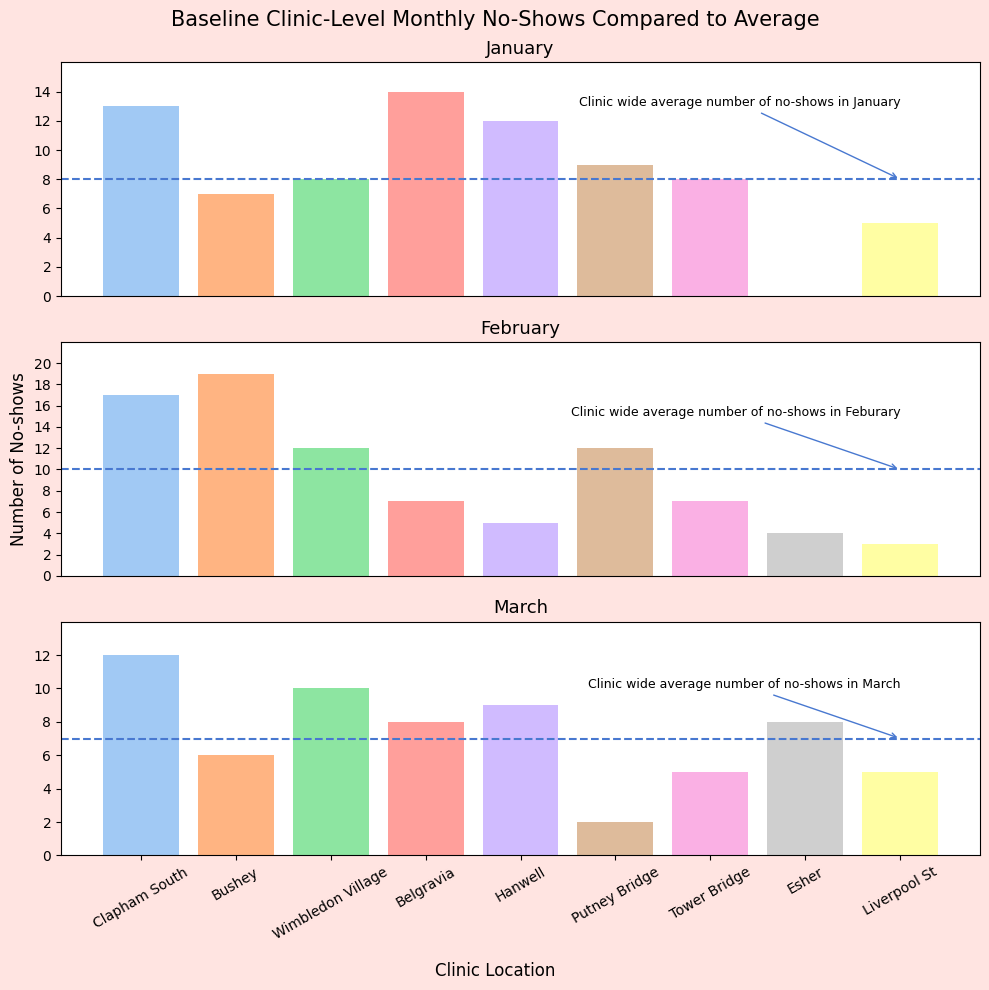

In [16]:
# Order data in terms of clinic baseline average
baseline_noshows = baseline_noshows.sort_values('baseline_average', ascending=False)

clinics = baseline_noshows['clinic']
jan_vals = baseline_noshows['jan_noshows']
feb_vals = baseline_noshows['feb_noshows']
mar_vals = baseline_noshows['mar_noshows']

# Setup Figure
fig = plt.figure(figsize= (10,10), tight_layout=True, facecolor ='mistyrose')
pastel_colours = sns.color_palette("pastel", n_colors=len(clinics))
axhline_color = sns.color_palette("muted")[0] 

plt.suptitle('Baseline Clinic-Level Monthly No-Shows Compared to Average', fontsize = 15)

# Subplot 1
plt.subplot(3,1,1)
plt.bar(clinics, jan_vals, color=pastel_colours)
plt.xticks([])
plt.axhline(jan_avg, linestyle='dashed', color = axhline_color)
plt.title('January', fontsize = 13)
plt.annotate(
    'Clinic wide average number of no-shows in January',
    xy=(len(clinics) - 1, jan_avg),               # Arrow points to last clinic's average line
    xytext=(len(clinics) - 1, jan_avg + 5),       # Text floats above it
    fontsize=9,
    color='black',
    ha='right',
    arrowprops=dict(arrowstyle='->'
, color=axhline_color)
)
plt.ylim(0,16)
plt.yticks(range(0,16,2))


# Sublot 2
plt.subplot(3,1,2)
plt.bar(clinics, feb_vals, color=pastel_colours)
plt.xticks([])
plt.ylabel('Number of No-shows', fontsize = 12)
plt.axhline(feb_avg, linestyle ='dashed', color = axhline_color)
plt.title('February', fontsize = 13)
plt.annotate(
    'Clinic wide average number of no-shows in Feburary',
    xy=(len(clinics) - 1, feb_avg),               # Arrow points to last clinic's average line
    xytext=(len(clinics) - 1, feb_avg + 5),       # Text floats above it
    fontsize=9,
    color='black',
    ha='right',
    arrowprops=dict(arrowstyle='->', color=axhline_color)
)
plt.ylim(0,22)
plt.yticks(range(0,22,2))


# Subplot 3
plt.subplot(3,1,3)
plt.bar(clinics, mar_vals, color = pastel_colours)
plt.xticks(rotation=30)
plt.axhline(mar_avg, linestyle='dashed', color = axhline_color)
plt.title('March', fontsize = 13)
plt.annotate(
    'Clinic wide average number of no-shows in March',
    xy=(len(clinics) - 1, mar_avg),               # Arrow points to last clinic's average line
    xytext=(len(clinics) - 1, mar_avg + 3),       # Text floats above it
    fontsize=9,
    color='black',
    ha='right',
    arrowprops=dict(arrowstyle='->', color=axhline_color)
)
plt.ylim(0,14)
plt.yticks(range(0,14,2))


# Tidy and format plots
fig.supxlabel('Clinic Location', fontsize = 12)
plt.subplots_adjust(hspace=0.1)  # Reduce vertical space between plots

# Save figure for presentation useage
plt.savefig('Baseline Clinic-Level Monthly No-Shows Compared to Average')




In [17]:
# Calculate monthly no-show % per row first
baseline['jan_noshows_percent'] = (baseline['jan_noshows'] / baseline['jan_consults'] * 100).round(0)
baseline['feb_noshows_percent'] = (baseline['feb_noshows'] / baseline['feb_consults'] * 100).round(0)
baseline['mar_noshows_percent'] = (baseline['mar_noshows'] / baseline['mar_consults'] * 100).round(0)

In [18]:
# Now group by clinic and condition, take mean % per month
baseline_noshows_percent = baseline.groupby(['clinic', 'condition']).agg({
    'jan_noshows_percent': 'mean',
    'feb_noshows_percent': 'mean',
    'mar_noshows_percent': 'mean'
}).reset_index()

# Calculate averages for each clinic and each month
baseline_noshows_percent['baseline_average'] = round(np.mean(baseline_noshows_percent[['jan_noshows_percent', 'feb_noshows_percent','mar_noshows_percent']], axis=1),0) # Rounding averages to zero decimal places since no-shows count whole individuals (cannot be fractional)

In [19]:
print(baseline_noshows_percent)

              clinic condition  jan_noshows_percent  feb_noshows_percent  mar_noshows_percent  baseline_average
0          Belgravia  Baseline                 18.0                 15.0                 16.0              16.0
1             Bushey  Baseline                 11.0                 29.0                 11.0              17.0
2      Clapham South  Baseline                 17.0                 19.0                 20.0              19.0
3              Esher  Baseline                  0.0                 11.0                 17.0               9.0
4            Hanwell  Baseline                 39.0                  8.0                 26.0              24.0
5       Liverpool St  Baseline                  9.0                  8.0                 14.0              10.0
6      Putney Bridge  Baseline                 17.0                 21.0                  5.0              14.0
7       Tower Bridge  Baseline                 15.0                 14.0                 14.0           

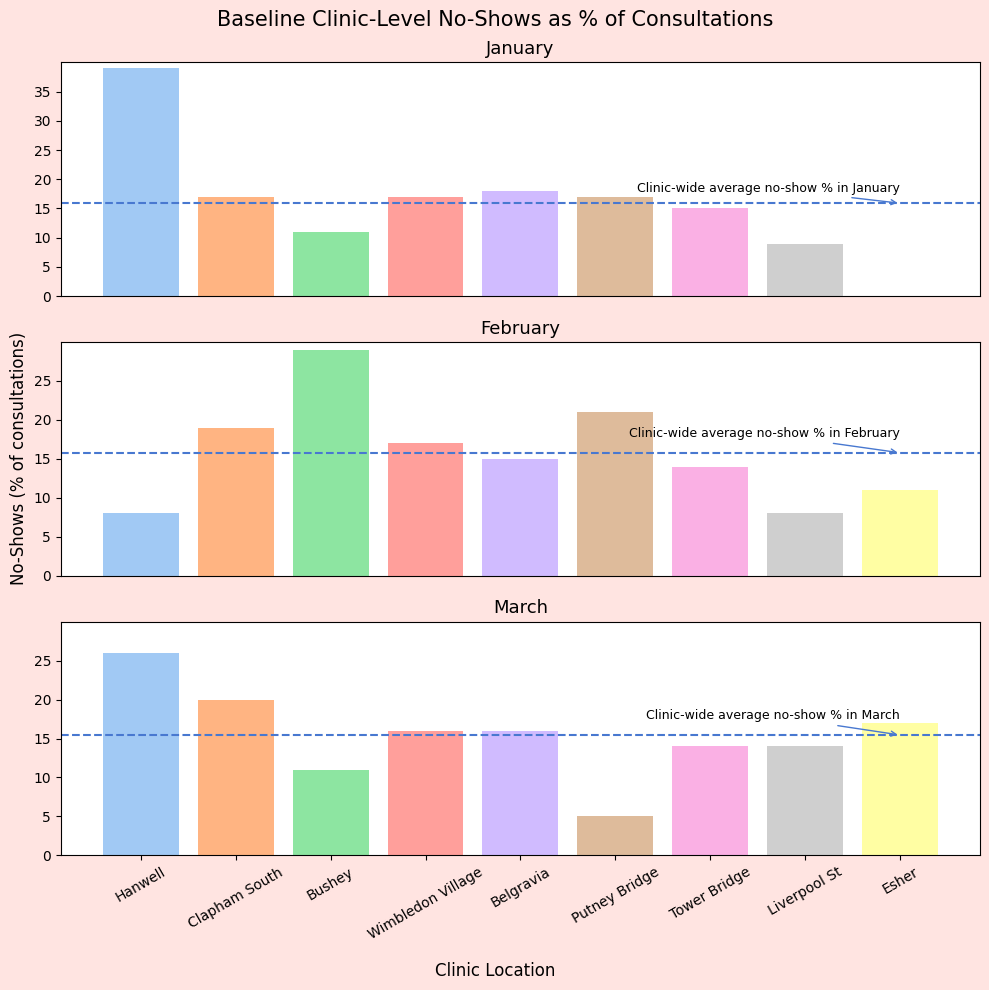

In [20]:
# Order data in terms of clinic baseline average (%)
baseline_noshows_percent = baseline_noshows_percent.sort_values('baseline_average', ascending=False)

clinics = baseline_noshows_percent['clinic']
jan_vals = baseline_noshows_percent['jan_noshows_percent']
feb_vals = baseline_noshows_percent['feb_noshows_percent']
mar_vals = baseline_noshows_percent['mar_noshows_percent']

# Monthly average % across clinics
jan_avg = jan_vals.mean()
feb_avg = feb_vals.mean()
mar_avg = mar_vals.mean()

# Setup Figure
fig = plt.figure(figsize=(10, 10), tight_layout=True, facecolor='mistyrose')
pastel_colours = sns.color_palette("pastel", n_colors=len(clinics))
axhline_color = sns.color_palette("muted")[0]

plt.suptitle('Baseline Clinic-Level No-Shows as % of Consultations', fontsize=15)

# Subplot 1 - January
plt.subplot(3, 1, 1)
plt.bar(clinics, jan_vals, color=pastel_colours)
plt.xticks([])
plt.axhline(jan_avg, linestyle='dashed', color=axhline_color)
plt.title('January', fontsize=13)
plt.annotate(
    'Clinic-wide average no-show % in January',
    xy=(len(clinics) - 1, jan_avg),
    xytext=(len(clinics) - 1, jan_avg + 2),
    fontsize=9,
    color='black',
    ha='right',
    arrowprops=dict(arrowstyle='->', color=axhline_color)
)
plt.ylim(0,40)
plt.yticks(range(0,40,5))

# Subplot 2 - February
plt.subplot(3, 1, 2)
plt.bar(clinics, feb_vals, color=pastel_colours)
plt.xticks([])
plt.ylabel('No-Shows (% of consultations)', fontsize=12)
plt.axhline(feb_avg, linestyle='dashed', color=axhline_color)
plt.title('February', fontsize=13)
plt.annotate(
    'Clinic-wide average no-show % in February',
    xy=(len(clinics) - 1, feb_avg),
    xytext=(len(clinics) - 1, feb_avg + 2),
    fontsize=9,
    color='black',
    ha='right',
    arrowprops=dict(arrowstyle='->', color=axhline_color)
)
plt.ylim(0,30)
plt.yticks(range(0,30,5))

# Subplot 3 - March
plt.subplot(3, 1, 3)
plt.bar(clinics, mar_vals, color=pastel_colours)
plt.xticks(rotation=30)
plt.axhline(mar_avg, linestyle='dashed', color=axhline_color)
plt.title('March', fontsize=13)
plt.annotate(
    'Clinic-wide average no-show % in March',
    xy=(len(clinics) - 1, mar_avg),
    xytext=(len(clinics) - 1, mar_avg + 2),
    fontsize=9,
    color='black',
    ha='right',
    arrowprops=dict(arrowstyle='->', color=axhline_color)
)
plt.ylim(0,30)
plt.yticks(range(0,30,5))

# Final formatting
fig.supxlabel('Clinic Location', fontsize=12)
plt.subplots_adjust(hspace=0.1)

# Save figure
plt.savefig('Baseline Clinic-Level Monthly No-Show Percentages')

Although the raw number of no shows might appear low at face value, averaging just 8 per clinic, this plot reveals that, when adjusted for the number of consultations, many clinics had significantly higher no show rates as a percentage of appointments. This context is essential when designing interventions, as it reflects true clinic impact rather than just raw counts.

#### Check to see any clinics behave unexpectedly (e.g. consult rates went up dramatically etc)?

In [21]:
# Identify consults in Baseline Data 
baseline_consults = baseline[['clinic','jan_consults','feb_consults','mar_consults']]

# Identify consults in Test Data
test_consults = test.groupby('clinic')[['april_consults','may_consults']].agg('sum').reset_index()

consults = pd.merge(
    baseline_consults,
    test_consults,
    on='clinic',
    how='outer'
)

# Calculate Average
consults['Average'] = consults[['jan_consults', 'feb_consults', 'mar_consults','april_consults', 'may_consults']].mean(axis=1)
consults['Average'] = consults['Average'].round(0).astype(int)

print(consults)

              clinic  jan_consults  feb_consults  mar_consults  april_consults  may_consults  Average
0          Belgravia            79            48            50              56            76       62
1             Bushey            64            66            56              60            68       63
2      Clapham South            77            90            60              76            88       78
3              Esher            49            35            47              44            56       46
4            Hanwell            31            62            35              40            48       43
5       Liverpool St            58            40            35              48            44       45
6      Putney Bridge            53            56            44              48            64       53
7       Tower Bridge            54            51            35              52            52       49
8  Wimbledon Village            48            72            63              60    

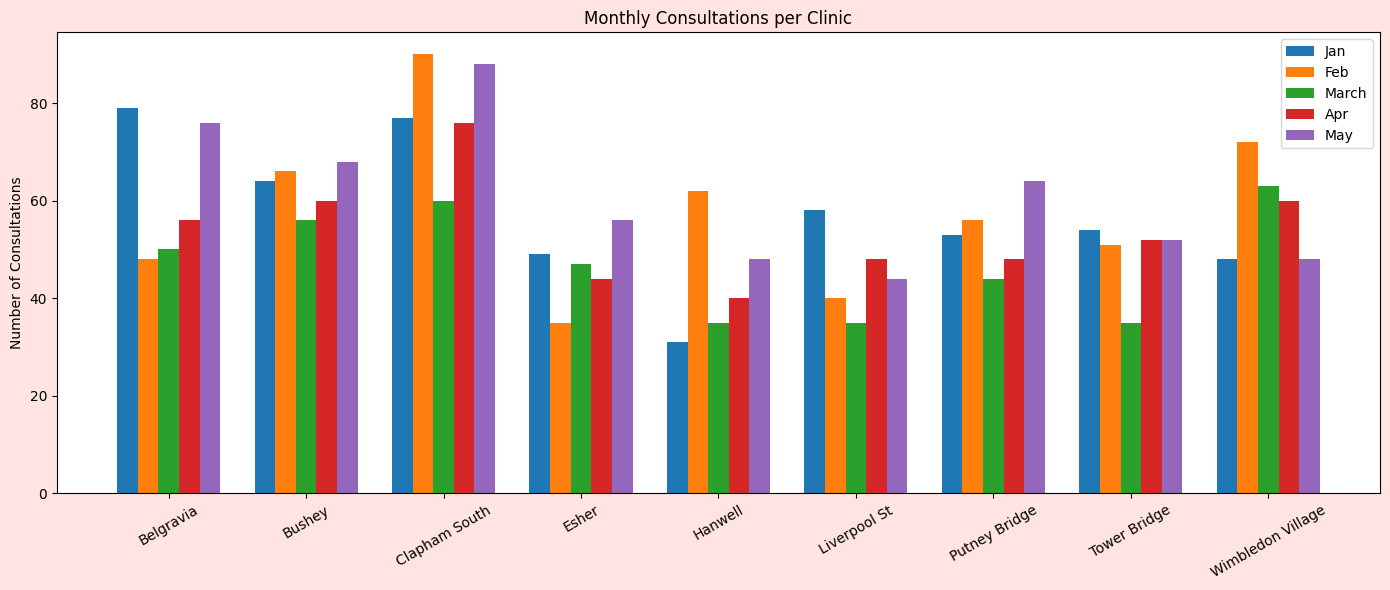

In [22]:
clinic_consults = consults['clinic']
jan_consults = consults['jan_consults']
feb_consults = consults['feb_consults']
mar_consults = consults['mar_consults']
april_consults = consults['april_consults']
may_consults = consults['may_consults']

# Order data in terms of average consults
consults = consults.sort_values('Average', ascending=False)

# Setup Figure
fig = plt.figure(figsize=(14, 6), tight_layout=True, facecolor='mistyrose')

# Setup x-axis positions
x = np.arange(len(clinic_consults))
bar_width = 0.15  # Narrower bars for more months

# Plot each month's data side by side
plt.bar(x - 2*bar_width, jan_consults, width=bar_width, label='Jan')
plt.bar(x - bar_width, feb_consults, width=bar_width, label='Feb')
plt.bar(x, mar_consults, width=bar_width, label='March')
plt.bar(x + bar_width, april_consults, width=bar_width, label='Apr')
plt.bar(x + 2*bar_width, may_consults, width=bar_width, label='May')


# Formatting
plt.xticks(x, clinic_consults, rotation=30)
plt.ylabel('Number of Consultations')
plt.title('Monthly Consultations per Clinic')
plt.legend()
plt.tight_layout()


# Save figure
plt.savefig('Monthly Consultations per Clinic')
plt.show()

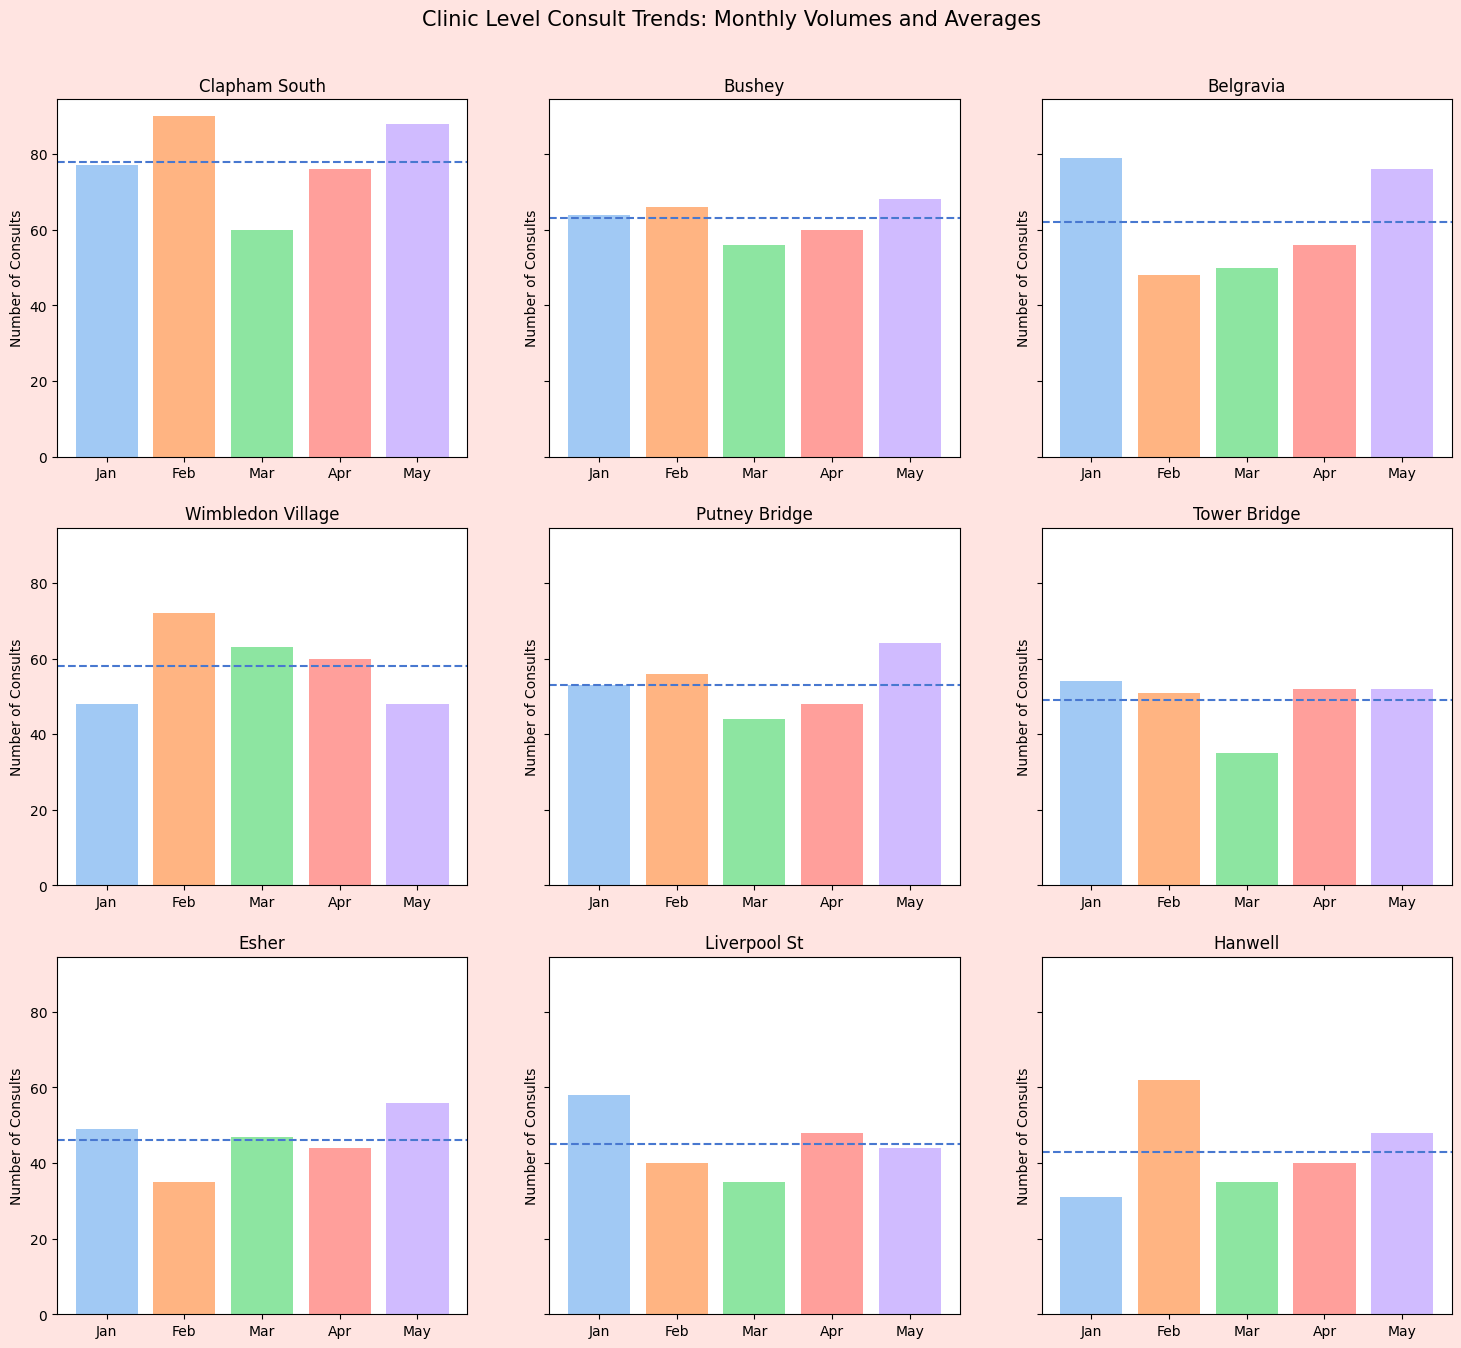

In [23]:
# Plot each location next to its month average for comparison
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
# Create a figure and a grid of subplots
num_types = len(consults)
num_rows = (num_types - 1) // 3 + 1  # Number of rows needed
num_cols = min(num_types, 3)          # Number of columns

# Setup the figure
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5*num_rows), sharey=True, facecolor='mistyrose')

axes = axes.flatten() # for easier indexing
for i, (index, clinic) in enumerate(consults.iterrows()):
    values = [
        clinic.get('jan_consults', np.nan),
        clinic.get('feb_consults', np.nan),
        clinic.get('mar_consults', np.nan),
        clinic.get('april_consults', np.nan),
        clinic.get('may_consults', np.nan),
    ]
    
    bar_colours = sns.color_palette("pastel", n_colors=len(months))
    axes[i].axhline(clinic.get('Average',np.nan), color = axhline_color, linestyle='dashed')
    axes[i].bar(months, values, color= bar_colours)
    axes[i].set_title(f"{clinic['clinic']}")
    axes[i].set_ylabel('Number of Consults')

plt.suptitle('Clinic Level Consult Trends: Monthly Volumes and Averages', fontsize=15)
fig.subplots_adjust(top=0.92)
# Save figure
plt.savefig('Clinic Level Consult Trends: Monthly Volumes and Averages.png')

### Standardising Clinic Performance Using Z-Scores

Using **z-scores** provides a standardised measure that accounts for differences in baseline performance and sample sizes across locations.

A **z-score** quantifies how many standard deviations an observation is from the mean of its distribution. It is calculated as:
$$
z = \frac{X - \mu}{\sigma}
$$
where:

- $X$ = observed value  
- $\mu$ = mean (average) value  
- $\sigma$ = standard deviation  

This standardisation enables us to objectively identify whether any fluctuations in consult numbers at a clinic are unusually large relative to its typical variation.

##### Rules of Thumb for Interpreting Z-Scores:

- $|z| < 1$: The observation is within one standard deviation of the mean — generally considered normal variation.  
- $1 \leq |z| < 2$: The observation is somewhat unusual and may warrant attention.  
- $|z| \geq 2$: The observation is considered statistically significant and indicates a noteworthy deviation that likely warrants further investigation.

By applying z-scores, we can flag locations whose changes in consult numbers are not likely due to random chance, facilitating targeted follow-up.

In [24]:
# Baseline mean and std
baseline_stats = baseline[['clinic', 'jan_consults', 'feb_consults', 'mar_consults']].copy()
baseline_stats['mean'] = baseline_stats[['jan_consults', 'feb_consults', 'mar_consults']].mean(axis=1)
baseline_stats['std'] = baseline_stats[['jan_consults', 'feb_consults', 'mar_consults']].std(axis=1)

# Test consults summed
test_consults = test.groupby('clinic')[['april_consults', 'may_consults']].sum().reset_index()

# Merge
merged_consults = pd.merge(baseline_stats[['clinic', 'mean', 'std']], test_consults, on='clinic', how='left')

# Calculate Z-scores
merged_consults['april_z'] = (merged_consults['april_consults'] - merged_consults['mean']) / merged_consults['std']
merged_consults['may_z'] = (merged_consults['may_consults'] - merged_consults['mean']) / merged_consults['std']

# Flag unexpected values
merged_consults['april_unexpected'] = merged_consults['april_z'].abs() > 2
merged_consults['may_unexpected'] = merged_consults['may_z'].abs() > 2

# View unexpected
unexpected = merged_consults[['clinic', 'april_z', 'april_unexpected', 'may_z', 'may_unexpected']]
print(unexpected[unexpected[['april_unexpected', 'may_unexpected']].any(axis=1)])

          clinic   april_z  april_unexpected     may_z  may_unexpected
6  Putney Bridge -0.480384             False  2.081666            True


Putney Bridge had a z-score of 2.08 in May, which is more than 2 standard deviations above its average. This suggests the Putney Bridges May consults value is statistically unusual, especially under the assumption of normal distribution.

In [25]:
print(consults.loc[consults['clinic'] == 'Putney Bridge',['clinic','jan_consults','feb_consults','mar_consults','april_consults','may_consults','Average']])

          clinic  jan_consults  feb_consults  mar_consults  april_consults  may_consults  Average
6  Putney Bridge            53            56            44              48            64       53


Whilst the z-score indicates a deviation of over 2 standard deviations in Putney Bridge’s May consultation count, visual inspection of their figures across the 5-month period suggests that this deviation may not be substantial. To assess the statistical significance of this fluctuation, a one-sample t-test was conducted.

One-sample t-test setup:
- Null hypothesis ($H_0$): May’s value is not significantly different from the mean of January–April.
- Alternative hypothesis ($H_1$): May’s value is significantly different from the mean of January–April.

The test compares May’s consultation count to the distribution of values from the four prior months. This allows us to determine whether the observed increase is likely to be due to chance or represents a statistically meaningful deviation.

In [26]:
# Extract Jan–Apr consults
PB_jan_to_apr = [53, 56, 44, 48]
PB_may = 64
# Run one-sample t-test comparing May (64) to Jan–Apr
t_stat, p_value = ttest_1samp(PB_jan_to_apr, popmean=PB_may)

print(f"t-statistic: {t_stat:.2f}, p-value: {p_value:.4f}")

# Interpret this result
alpha = 0.05
if p_value < alpha:
    print("Result: The difference is statistically significant. May's consults are unusually different from previous months.")
else:
    print("Result: The difference is not statistically significant. May's consults are within expected variation.")

t-statistic: -5.17, p-value: 0.0140
Result: The difference is statistically significant. May's consults are unusually different from previous months.


Putney Bridge showed a statistically significant increase in May consultations (Z = 2.08, p = 0.014). However, no marketing campaigns or structural changes were reported for this period, and no other clinic exhibited a similar spike. While the statistical result is notable, the magnitude of the increase (from an average of ~50 to 64) is moderate and could reflect:
- Natural month-to-month variability
- Regression to the mean, following a slightly lower April
- Unobserved local factors (e.g., staffing or community demand)

Therefore, this deviation is acknowledged but does not warrant exclusion or separate modelling. We proceed with the main analysis, noting this as a mild local anomaly worth monitoring in future datasets.

### Did no-show rates drop across all clinics after the new messages were introduced?

In [27]:
test_noshow_rates = test.groupby('clinic')[['april_consults', 'april_noshows','may_consults', 'may_noshows']].agg('sum').reset_index()
print(test_noshow_rates)

              clinic  april_consults  april_noshows  may_consults  may_noshows
0          Belgravia              56             10            76            6
1             Bushey              60             14            68            9
2      Clapham South              76             10            88           10
3              Esher              44              8            56            9
4            Hanwell              40              7            48            7
5       Liverpool St              48             12            44            6
6      Putney Bridge              48             15            64            9
7       Tower Bridge              52             12            52            6
8  Wimbledon Village              60             11            48            8


In [28]:
test_noshow_rates['april_noshows_percent'] = (test_noshow_rates['april_noshows'] / test_noshow_rates['april_consults'] * 100).round(0)
test_noshow_rates['may_noshows_percent'] = (test_noshow_rates['may_noshows'] / test_noshow_rates['may_consults'] * 100).round(0)
test_noshow_rates['test_avg_noshows_percent'] = (
    (test_noshow_rates['april_noshows'] + test_noshow_rates['may_noshows']) /
    (test_noshow_rates['april_consults'] + test_noshow_rates['may_consults']) * 100
).round(1)

print(test_noshow_rates)

              clinic  april_consults  april_noshows  may_consults  may_noshows  april_noshows_percent  may_noshows_percent  test_avg_noshows_percent
0          Belgravia              56             10            76            6                   18.0                  8.0                      12.1
1             Bushey              60             14            68            9                   23.0                 13.0                      18.0
2      Clapham South              76             10            88           10                   13.0                 11.0                      12.2
3              Esher              44              8            56            9                   18.0                 16.0                      17.0
4            Hanwell              40              7            48            7                   18.0                 15.0                      15.9
5       Liverpool St              48             12            44            6                   25.0     

In [29]:
noshow_rates = pd.merge(test_noshow_rates, baseline_noshows_percent,
                        on='clinic',
                        how='outer')
print(noshow_rates)

              clinic  april_consults  april_noshows  may_consults  may_noshows  april_noshows_percent  may_noshows_percent  test_avg_noshows_percent condition  jan_noshows_percent  feb_noshows_percent  mar_noshows_percent  baseline_average
0          Belgravia              56             10            76            6                   18.0                  8.0                      12.1  Baseline                 18.0                 15.0                 16.0              16.0
1             Bushey              60             14            68            9                   23.0                 13.0                      18.0  Baseline                 11.0                 29.0                 11.0              17.0
2      Clapham South              76             10            88           10                   13.0                 11.0                      12.2  Baseline                 17.0                 19.0                 20.0              19.0
3              Esher              44    

In [30]:
noshow_rates = noshow_rates.drop(columns = ['may_noshows','april_noshows'])
noshow_rates = noshow_rates[['clinic','condition','jan_noshows_percent','feb_noshows_percent', 'mar_noshows_percent','april_noshows_percent','may_noshows_percent','baseline_average','test_avg_noshows_percent']]
print(noshow_rates)

              clinic condition  jan_noshows_percent  feb_noshows_percent  mar_noshows_percent  april_noshows_percent  may_noshows_percent  baseline_average  test_avg_noshows_percent
0          Belgravia  Baseline                 18.0                 15.0                 16.0                   18.0                  8.0              16.0                      12.1
1             Bushey  Baseline                 11.0                 29.0                 11.0                   23.0                 13.0              17.0                      18.0
2      Clapham South  Baseline                 17.0                 19.0                 20.0                   13.0                 11.0              19.0                      12.2
3              Esher  Baseline                  0.0                 11.0                 17.0                   18.0                 16.0               9.0                      17.0
4            Hanwell  Baseline                 39.0                  8.0                 2

In [31]:
# List of monthly columns for no-show percentages
months = ['jan_noshows_percent', 'feb_noshows_percent', 'mar_noshows_percent', 
          'april_noshows_percent', 'may_noshows_percent']

# Convert to long format for seaborn barplot
noshow_months_long = noshow_rates.melt(
    id_vars='clinic',
    value_vars=months,
    var_name='month',
    value_name='no_show_percent'
)

# Clean month names for nicer x-axis labels
noshow_months_long['month'] = noshow_months_long['month'].str.replace('_noshows_percent', '').str.title()

# Calculate overall averages across clinics
overall_baseline_avg = noshow_rates['baseline_average'].mean()
overall_test_avg = noshow_rates['test_avg_noshows_percent'].mean()

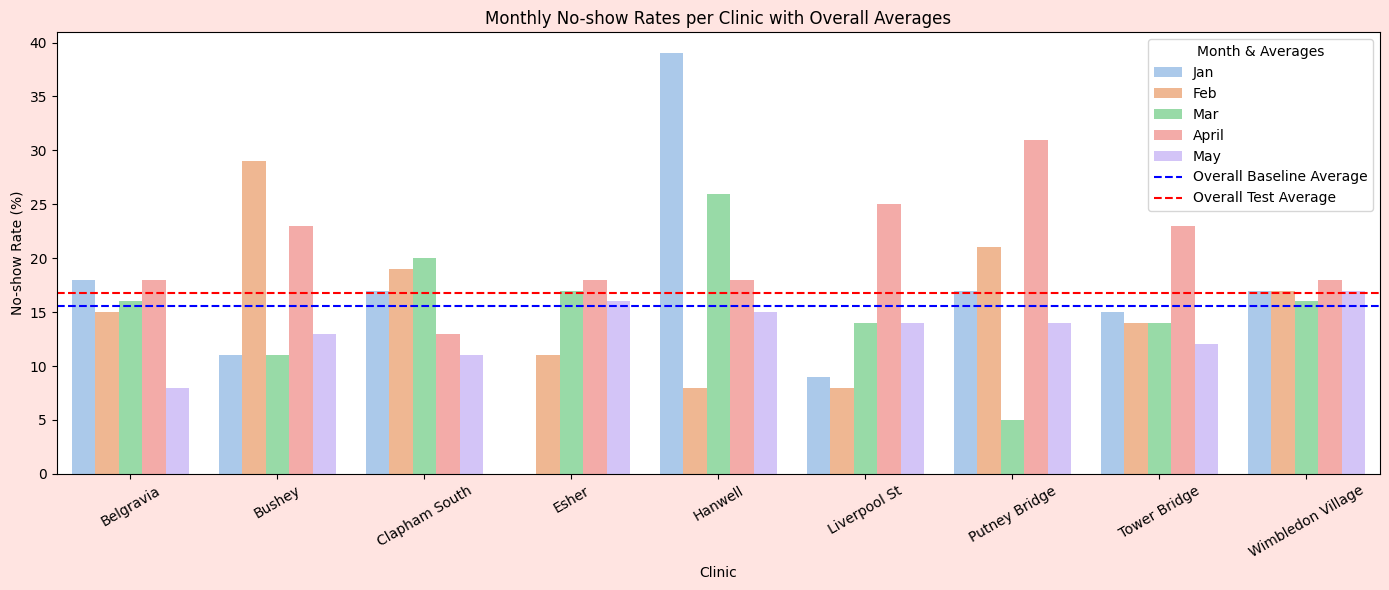

In [32]:
plt.figure(figsize=(14, 6), facecolor='mistyrose')

# Plot bars for monthly no-show rates per clinic
sns.barplot(data=noshow_months_long, x='clinic', y='no_show_percent', hue='month', palette='pastel')

# Add overall baseline average line
plt.axhline(overall_baseline_avg, color='blue', linestyle='--', label='Overall Baseline Average')

# Add overall test average line
plt.axhline(overall_test_avg, color='red', linestyle='--', label='Overall Test Average')

plt.xlabel('Clinic')
plt.ylabel('No-show Rate (%)')
plt.title('Monthly No-show Rates per Clinic with Overall Averages')
plt.xticks(rotation=30)
plt.legend(title='Month & Averages')
plt.tight_layout()


plt.savefig('Monthly No-show Rates per Clinic with Overall Averages')
plt.show()

In [33]:
# Group by clinic and condition, sum consults and no-shows for April and May
test_rates = test.groupby(['clinic', 'condition']).agg({
    'april_consults': 'sum',
    'april_noshows': 'sum',
    'may_consults': 'sum',
    'may_noshows': 'sum'
}).reset_index()

# Calculate no-show rates for April and May
test_rates['april_noshows_percent'] = (test_rates['april_noshows'] / test_rates['april_consults'] * 100).round(1)
test_rates['may_noshows_percent'] = (test_rates['may_noshows'] / test_rates['may_consults'] * 100).round(1)

# Keep only relevant columns
test_rates = test_rates[['clinic', 'condition', 'april_noshows_percent', 'may_noshows_percent']]

print(test_rates.head())


      clinic      condition  april_noshows_percent  may_noshows_percent
0  Belgravia     ClientName                   14.3                  0.0
1  Belgravia        Control                   35.7                 21.1
2  Belgravia    Reciprocity                   14.3                  0.0
3  Belgravia  SchedulerName                    7.1                 10.5
4     Bushey     ClientName                   20.0                  5.9


In [34]:
# Melt baseline data (Jan–Mar)
baseline_long = pd.melt(
    noshow_rates,
    id_vars=['clinic'],
    value_vars=['jan_noshows_percent', 'feb_noshows_percent', 'mar_noshows_percent'],
    var_name='month',
    value_name='noshows_percent'
)

# Clean month names
baseline_long['month'] = baseline_long['month'].str.replace('_noshows_percent', '').str.capitalize()
baseline_long['condition'] = 'Baseline'

# Melt test data (April & May)
test_long = pd.melt(
    test_rates,
    id_vars=['clinic', 'condition'],
    value_vars=['april_noshows_percent', 'may_noshows_percent'],
    var_name='month',
    value_name='noshows_percent'
)

# Clean month names
test_long['month'] = test_long['month'].str.replace('_noshows_percent', '').str.capitalize()

# Combine both
combined_long = pd.concat([baseline_long, test_long], ignore_index=True)

# Organise
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May']
combined_long['month'] = pd.Categorical(combined_long['month'], categories=month_order, ordered=True)
combined_long = combined_long.sort_values(by=['clinic','month'], ascending=[True, True])
combined_long['month'] = combined_long['month'].fillna('Apr')
print(combined_long)

               clinic month  noshows_percent      condition
0           Belgravia   Jan             18.0       Baseline
9           Belgravia   Feb             15.0       Baseline
18          Belgravia   Mar             16.0       Baseline
63          Belgravia   May              0.0     ClientName
64          Belgravia   May             21.1        Control
..                ...   ...              ...            ...
98  Wimbledon Village   May              0.0  SchedulerName
59  Wimbledon Village   Apr             20.0     ClientName
60  Wimbledon Village   Apr             33.3        Control
61  Wimbledon Village   Apr              6.7    Reciprocity
62  Wimbledon Village   Apr             13.3  SchedulerName

[99 rows x 4 columns]


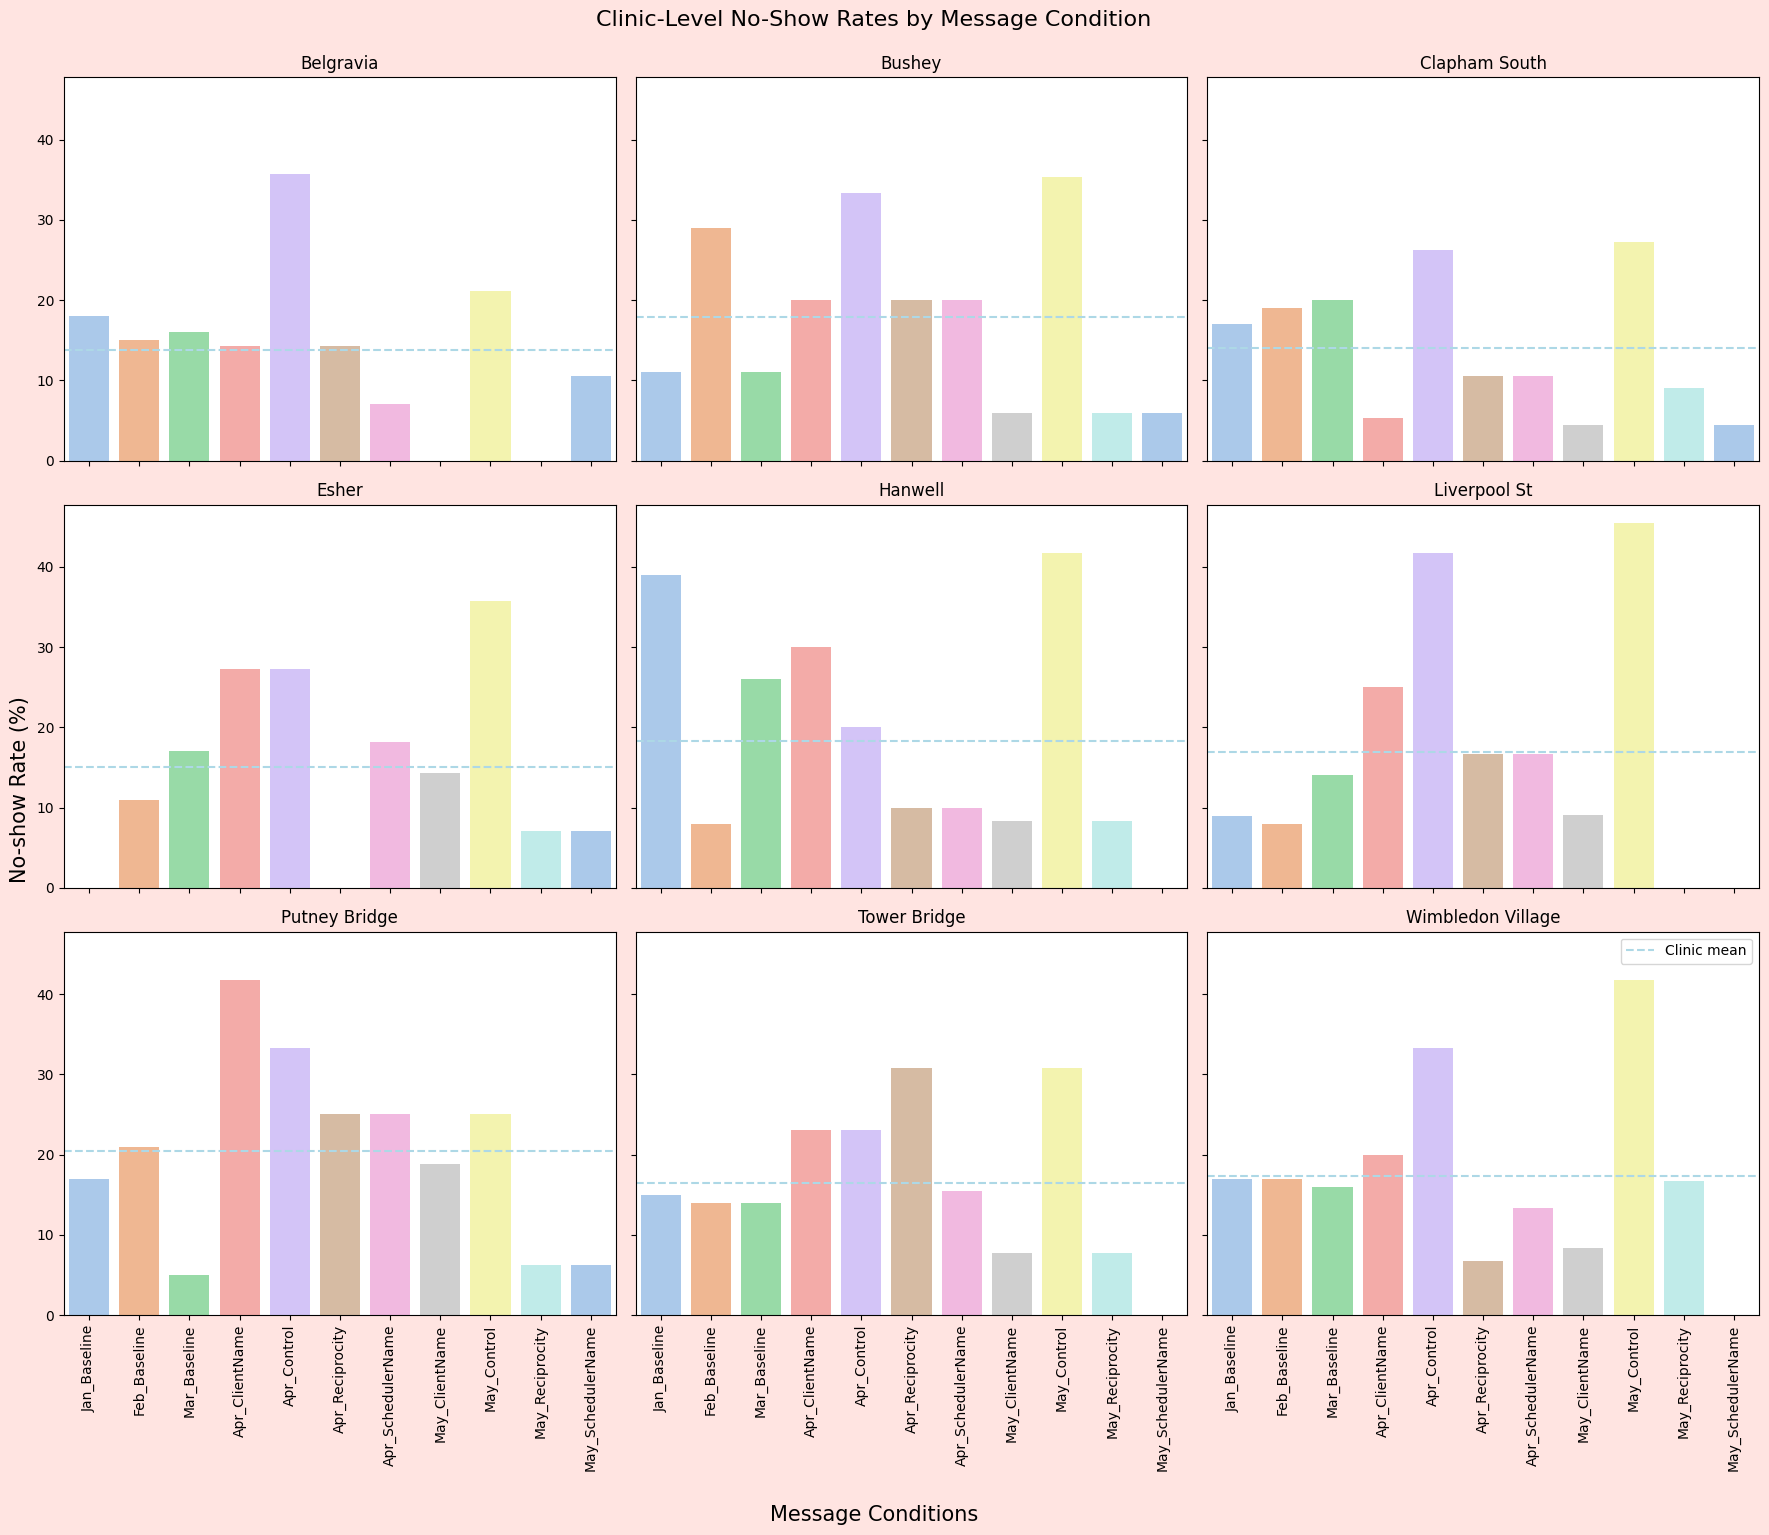

In [35]:
# Ignore deprication warnings related to plot colour scheme
if not sys.warnoptions:
    warnings.filterwarnings("ignore", category=FutureWarning)
    
# For baseline months, keep condition = 'Baseline'
baseline_months = ['Jan', 'Feb', 'Mar']
baseline_df = combined_long[
    (combined_long['condition'] == 'Baseline') & 
    (combined_long['month'].isin(baseline_months))
].copy()

# For test months, all conditions, but only Apr and May
test_months = ['Apr', 'May']
test_df = combined_long[
    (combined_long['month'].isin(test_months)) & 
    (combined_long['condition'] != 'Baseline')
].copy()

# Combine baseline and test, create a 'time_condition' column
baseline_df['time_condition'] = baseline_df['month'].astype(str) + '_Baseline'
test_df['time_condition'] = test_df['month'].astype(str) + '_' + test_df['condition'].astype(str)

plot_df = pd.concat([baseline_df, test_df])

# Sort time_condition to keep a consistent order on x-axis
time_order = (
    [m + '_Baseline' for m in baseline_months] +
    [m + '_' + c for m in test_months for c in test_df['condition'].unique()]
)
plot_df['time_condition'] = pd.Categorical(plot_df['time_condition'], categories=time_order, ordered=True)

# Get clinics
clinics = plot_df['clinic'].unique()
num_clinics = len(clinics)

# Setup subplots grid (3 per row)
num_cols = 3
num_rows = (num_clinics - 1) // num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 5*num_rows), sharey=True, facecolor='mistyrose')
axes = axes.flatten()

for i, clinic in enumerate(clinics):
    ax = axes[i]
    data = plot_df[plot_df['clinic'] == clinic]
    sns.barplot(
        ax=ax,
        data=data,
        x='time_condition',
        y='noshows_percent',
        palette='pastel',
        order=time_order,
        #hue='time_condition',
        legend=False
    )
    ax.set_title(clinic)

   # Show x-axis labels only for bottom row
    if i // num_cols == num_rows - 1:
        ax.tick_params(axis='x', labelbottom=True, rotation=90)
    else:
        ax.tick_params(axis='x', labelbottom=False)

    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.axhline(y=data['noshows_percent'].mean(), color='lightblue', linestyle='dashed', label='Clinic mean')

# Remove empty subplots if any
#for j in range(i+1, len(axes)):
   # fig.delaxes(axes[j])

fig.supylabel('No-show Rate (%)', fontsize=15)
fig.tight_layout()
fig.subplots_adjust(left=0.05, bottom=0.15)
fig.supxlabel('Message Conditions', fontsize=15)
fig.suptitle('Clinic-Level No-Show Rates by Message Condition', fontsize=16, y=1.02)
plt.legend(loc='upper right')


plt.savefig('Clinic-Level No-Show Rates by Message Condition.png')
plt.show()

### Analysing Test Data

In [36]:
# Develop rates 
test['april_show_rate'] = ((test['april_consults'] - test['april_noshows']) / test['april_consults'] * 100).round(2)
test['may_show_rate'] = ((test['may_consults'] - test['may_noshows']) / test['may_consults'] * 100).round(2)

In [37]:
# Group data according to clinic and condition for analysis
grouped = test.groupby(['clinic', 'condition']).agg({'april_show_rate': 'mean','may_show_rate':'mean'}).reset_index()

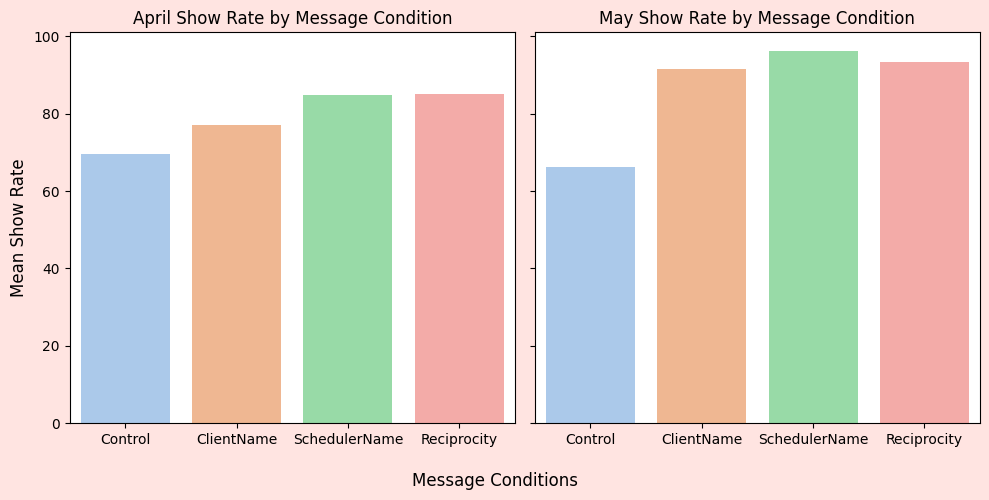

In [38]:
# Visual examination before statistical testing
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True, tight_layout=True, facecolor='mistyrose') # setup figure space
condition_order = ['Control', 'ClientName', 'SchedulerName', 'Reciprocity'] # align conditions with overall experiment

# Plot for April rates
sns.barplot(data=grouped,
            x='condition',
            y='april_show_rate',
            ci=False,
            ax=axes[0],
            order=condition_order,
            palette='pastel')

axes[0].set_ylabel('Mean Show Rate', fontsize = 12)
axes[0].set_title('April Show Rate by Message Condition', fontsize = 12)
axes[0].set_xlabel('')

# Plot for May rates
sns.barplot(data=grouped,
            x='condition',
            y='may_show_rate',
            ci=False,
            ax=axes[1],
            order=condition_order,
            palette='pastel')

axes[1].set_title('May Show Rate by Message Condition', fontsize = 12)
axes[1].set_xlabel('')

# Formating
fig.supxlabel('Message Conditions', fontsize = 12)
plt.savefig('Show Rates by Message Conditions.png')
plt.show()



In [39]:
#g = sns.catplot(
    #data=grouped,
    #x='condition',
    #y='april_show_rate',
    #col='clinic',
    #kind='bar',
    #ci=False,
    #col_wrap=3,
    #palette='pastel')
#g.fig.subplots_adjust(top=0.9)
#g.fig.suptitle('Show Rates by Condition per Clinic')

In [40]:
def chi_square_all_clinics(df, consult_col, show_col):
    clinics = df['clinic'].unique()
    results = []

    for clinic in clinics:
        clinic_data = df[df['clinic'] == clinic]
        
        contingency = []
        for condition in ['Control', 'ClientName', 'SchedulerName', 'Reciprocity']:
            shows = clinic_data[clinic_data['condition'] == condition][show_col].values[0]
            no_shows = clinic_data[clinic_data['condition'] == condition][consult_col].values[0] - shows
            contingency.append([shows, no_shows])

        contingency_table = pd.DataFrame(contingency, index=['Control', 'ClientName', 'SchedulerName', 'Reciprocity'], columns=['Show', 'No-show']).T
        
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        results.append({
            'clinic': clinic,
            'chi2': chi2,
            'p_value': p,
            'degrees_of_freedom': dof
        })
    
    return pd.DataFrame(results)

# Run for April
results_april = chi_square_all_clinics(test, 'april_consults', 'april_shows')

# Run for May
results_may = chi_square_all_clinics(test, 'may_consults', 'may_shows')

print("April results:\n", results_april)
print("\nMay results:\n", results_may)

April results:
               clinic      chi2   p_value  degrees_of_freedom
0      Clapham South  4.145455  0.246180                   3
1       Tower Bridge  0.866667  0.833464                   3
2  Wimbledon Village  3.896104  0.272904                   3
3       Liverpool St  2.666667  0.445922                   3
4              Esher  3.666667  0.299781                   3
5             Bushey  1.118012  0.772728                   3
6      Putney Bridge  1.066667  0.785126                   3
7          Belgravia  4.382609  0.223003                   3
8            Hanwell  1.904762  0.592407                   3

May results:
               clinic       chi2   p_value  degrees_of_freedom
0      Clapham South   7.671795  0.053305                   3
1       Tower Bridge   6.782609  0.079159                   3
2  Wimbledon Village   8.400000  0.038429                   3
3       Liverpool St  13.122807  0.004378                   3
4              Esher   5.692671  0.127558        

In April, no clinic showed a statistically significant difference in no-show rates across the four message types (all p-values > 0.05). However, Belgravia and Clapham South had the lowest p-values, suggesting early signs of a potential trend. By May, six clinics Wimbledon Village, Liverpool St, Bushey, Belgravia, Hanwell, and possibly Clapham South (p = 0.053) showed a statistically significant or near-significant reduction in no-show rates that varied by message condition. This pattern could suggest that the behavioural message variants became more effective over time, potentially due to cumulative exposure or delayed behavioural uptake across the client base.

In [41]:
def pool_and_test(df, consult_col, show_col, cond_col='condition'):
    # Aggregate total shows and no-shows per condition across all clinics
    agg = df.groupby(cond_col).agg(
        total_consults=(consult_col, 'sum'),
        total_shows=(show_col, 'sum')
    ).reset_index()
    
    # Calculate no-shows
    agg['total_noshows'] = agg['total_consults'] - agg['total_shows']
    
    # Build contingency table: rows = conditions, columns = [shows, no-shows]
    contingency_table = agg[[ 'total_shows', 'total_noshows']].to_numpy()
    
    # Run Chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    print("Pooled Chi-square test for all clinics:")
    print(f"Chi2 Statistic: {chi2:.4f}")
    print(f"Degrees of Freedom: {dof}")
    print(f"P-value: {p:.4f}")

    return chi2, p, dof, expected, contingency_table

# April data:
chi2_april, p_april, dof_april, expected_april, table_april = pool_and_test(test, consult_col='april_consults', show_col='april_shows')

# May data:
chi2_may, p_may, dof_may, expected_may, table_may = pool_and_test(test, consult_col='may_consults', show_col='may_shows')

Pooled Chi-square test for all clinics:
Chi2 Statistic: 12.3302
Degrees of Freedom: 3
P-value: 0.0063
Pooled Chi-square test for all clinics:
Chi2 Statistic: 62.2370
Degrees of Freedom: 3
P-value: 0.0000


### Pooled Analysis Across All Clinics

When data were pooled across all nine clinics, the effect of message condition on no-show rates was statistically significant in both April and May.

In **April**, the pooled Chi-square test indicated a significant difference across message types:

$$
\chi^2(3) = 12.33,\quad p = 0.0063
$$

In **May**, this effect was even more pronounced:

$$
\chi^2(3) = 62.24,\quad p < 0.0001
$$

These results provide strong evidence that the type of reminder message influenced appointment attendance overall, and that this influence intensified over time. The increasing strength of the effect suggests that continued exposure to behavioural message variants may have enhanced their impact.

In [42]:
# Group by condition and sum total consults and shows
summary = test.groupby('condition').agg({
    'april_consults': 'sum',
    'april_shows': 'sum',
    'may_consults': 'sum',
    'may_shows': 'sum'
}).reset_index()

# Calculate show and no-show rates
summary['april_show_rate'] = summary['april_shows'] / summary['april_consults']
summary['april_noshow_rate'] = 1 - summary['april_show_rate']

summary['may_show_rate'] = summary['may_shows'] / summary['may_consults']
summary['may_noshow_rate'] = 1 - summary['may_show_rate']

# Display results rounded for readability
print(summary[['condition', 
         'april_consults', 'april_shows', 'april_show_rate', 'april_noshow_rate',
         'may_consults', 'may_shows', 'may_show_rate', 'may_noshow_rate']
       ].round(3))

       condition  april_consults  april_shows  april_show_rate  april_noshow_rate  may_consults  may_shows  may_show_rate  may_noshow_rate
0     ClientName             121           95            0.785              0.215           136        125          0.919            0.081
1        Control             121           84            0.694              0.306           136         92          0.676            0.324
2    Reciprocity             121          103            0.851              0.149           136        127          0.934            0.066
3  SchedulerName             121          103            0.851              0.149           136        130          0.956            0.044


### Proportion z-tests comparing each message condition vs Control for May

In [43]:
# Calculate no-show counts
summary['may_noshows'] = summary['may_consults'] - summary['may_shows']

# Define the control group values
control_row = summary[summary['condition'] == 'Control'].iloc[0]
control_shows = control_row['may_shows']
control_total = control_row['may_consults']

# Store results
z_test_results = []

# Compare each condition to Control
for _, row in summary.iterrows():
    if row['condition'] == 'Control':
        continue
    count = [row['may_shows'], control_shows]
    nobs = [row['may_consults'], control_total]
    z_stat, p_val = proportions_ztest(count, nobs)
    z_test_results.append({
        'comparison': f"{row['condition']} vs Control",
        'z_stat': round(z_stat, 2),
        'p_value': p_val
    })

# Convert to DataFrame
z_results_df = pd.DataFrame(z_test_results)

# Display results
print(z_results_df)

                 comparison  z_stat       p_value
0     ClientName vs Control    4.98  6.299219e-07
1    Reciprocity vs Control    5.36  8.420688e-08
2  SchedulerName vs Control    5.95  2.706314e-09


All three behavioural message variants (ClientName, SchedulerName, and Reciprocity) had significantly lower no-show rates than the Control condition ($p < 0.001$ in all comparisons). This suggests that behavioural messaging, especially the inclusion of the scheduler’s name, substantially improved appointment attendance in May. ￼

### Further investigating condition impact by comparing the above results with April and across Locations 

In [44]:
def z_test_vs_control_by_month(df, month_consults_col, month_shows_col):
    results = []

    # Get unique clinics and conditions
    clinics = df['clinic'].unique()
    conditions = df['condition'].unique()

    for clinic in clinics:
        # Filter data for this clinic
        clinic_data = df[df['clinic'] == clinic]

        # Extract control data for the clinic
        control_row = clinic_data[clinic_data['condition'] == 'Control'].iloc[0]
        control_shows = control_row[month_shows_col]
        control_total = control_row[month_consults_col]

        for cond in conditions:
            if cond == 'Control':
                continue

            cond_row = clinic_data[clinic_data['condition'] == cond].iloc[0]
            cond_shows = cond_row[month_shows_col]
            cond_total = cond_row[month_consults_col]

            counts = [cond_shows, control_shows]
            nobs = [cond_total, control_total]

            z_stat, p_val = proportions_ztest(counts, nobs)

            results.append({
                'clinic': clinic,
                'comparison': f'{cond} vs Control',
                'month': month_consults_col.split('_')[0].capitalize(),
                'z_stat': round(z_stat, 3),
                'p_value': p_val
            })

    return pd.DataFrame(results)

# Run for April
april_results = z_test_vs_control_by_month(test, 'april_consults', 'april_shows')

# Run for May
may_results = z_test_vs_control_by_month(test, 'may_consults', 'may_shows')

# Combine results for display
all_results = pd.concat([april_results, may_results]).reset_index(drop=True)

print(all_results)

               clinic                comparison  month  z_stat   p_value
0       Clapham South     ClientName vs Control  April   1.780  0.075156
1       Clapham South  SchedulerName vs Control  April   1.255  0.209332
2       Clapham South    Reciprocity vs Control  April   1.255  0.209332
3        Tower Bridge     ClientName vs Control  April   0.000  1.000000
4        Tower Bridge  SchedulerName vs Control  April   0.498  0.618757
5        Tower Bridge    Reciprocity vs Control  April  -0.442  0.658387
6   Wimbledon Village     ClientName vs Control  April   0.826  0.408961
7   Wimbledon Village  SchedulerName vs Control  April   1.295  0.195321
8   Wimbledon Village    Reciprocity vs Control  April   1.826  0.067889
9        Liverpool St     ClientName vs Control  April   0.866  0.386476
10       Liverpool St  SchedulerName vs Control  April   1.347  0.177895
11       Liverpool St    Reciprocity vs Control  April   1.347  0.177895
12              Esher     ClientName vs Control  Ap

### Results: Pairwise Comparisons of Message Conditions vs Control

#### April Results  
No message condition showed a statistically significant improvement over the Control in any clinic at the \(\alpha = 0.05\) level. However, several comparisons indicated trends toward improvement:  
- **Clapham South**: *ClientName* vs Control (\(z = 1.78, p = 0.075\))  
- **Wimbledon Village**: *Reciprocity* vs Control (\(z = 1.83, p = 0.068\))  
- **Esher**: *Reciprocity* vs Control (\(z = 1.86, p = 0.062\))  
- **Belgravia**: *SchedulerName* vs Control (\(z = 1.84, p = 0.065\))  

These near-significant results suggested that some behavioural message variants may have begun to outperform the Control in select clinics by April, although the evidence was not conclusive.

#### May Results  
Stronger effects were observed in May, with several message conditions yielding statistically significant improvements in show rates compared to Control:  
- **Clapham South**: *ClientName* and *SchedulerName* messages both significantly improved attendance (\(p \approx 0.039\))  
- **Tower Bridge**: *SchedulerName* message significantly improved attendance (\(p \approx 0.030\))  
- **Wimbledon Village**: *SchedulerName* message significantly improved attendance (\(p \approx 0.012\))  
- **Liverpool St**: Both *SchedulerName* and *Reciprocity* messages significantly improved attendance (\(p \approx 0.011\))  
- **Bushey**: All three messages (*ClientName*, *SchedulerName*, *Reciprocity*) significantly improved attendance (\(p \approx 0.034\))  
- **Belgravia**: *ClientName* and *Reciprocity* messages significantly improved attendance (\(p \approx 0.034\))  
- **Hanwell**: *SchedulerName* message significantly improved attendance (\(p \approx 0.012\))  

Several other comparisons showed marginally significant trends.

#### Interpretation  
The lack of significant differences in April followed by clear improvements in May suggested that the behavioural message variants became more effective over time or with continued exposure. The *SchedulerName* message condition, in particular, demonstrated consistent significant improvements across multiple clinics in May, indicating that behavioural personalisation based on scheduler names may have been especially impactful. Additionally, clinics such as Bushey and Liverpool St showed robust improvements across multiple message conditions, suggesting site-specific responsiveness to the intervention.

---